In [4]:
import numpy as np

def binomial_european_crr(S0, K, T, r, sigma, N, option_type='call', q=0.0):
    """


    S0 : float
        Current stock price.
    K : float
        Strike price.
    T : float
        Time to maturity (in years).
    r : float
        Risk-free interest rate (continuously compounded).
    sigma : float
        Volatility (annualized).
    N : int
        Number of time steps.
    option_type : str
        'call' or 'put'.
    q : float
        Dividend yield (annualized, continuous). For TSLA, use 0.

    """
    dt = T / N

    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u

    disc = np.exp(-r * dt)
    p = (np.exp((r - q) * dt) - d) / (u - d)

 
    if p < 0 or p > 1:
        raise ValueError(f"Risk-neutral probability out of bounds: p={p:.4f}. "
                         "Check r, sigma, dt, or N.")

  
    j = np.arange(N + 1)
    ST = S0 * (u ** j) * (d ** (N - j))

  
    if option_type == 'call':
        V = np.maximum(ST - K, 0.0)
    elif option_type == 'put':
        V = np.maximum(K - ST, 0.0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

   
    for i in range(N - 1, -1, -1):
        V = disc * (p * V[1:i+2] + (1 - p) * V[0:i+1])

    price = V[0]
    return price


In [5]:
import numpy as np

def build_stock_tree(S0, T, r, sigma, N, q=0.0):
    """
    Build the CRR stock price tree as a list of numpy arrays.
    level i (0..N) contains stock prices at time i*dt.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    tree = []
    for i in range(N + 1):
        j = np.arange(i + 1)
        S_i = S0 * (u ** j) * (d ** (i - j))
        tree.append(S_i)
    return tree

def print_stock_tree(tree):
    """
    Print stock tree horizontally (time steps along columns).
    """
    N = len(tree) - 1
    for i, level in enumerate(tree):

        indent = " " * (2 * (N - i))
        values = "   ".join(f"{s:8.2f}" for s in level)
        print(f"t={i:2d}: {indent}{values}")


In [12]:
S0 = 250
T = 1.0
r = 0.03
sigma = 0.6
N = 4

tree = build_stock_tree(S0, T, r, sigma, N)
print_stock_tree(tree)


t= 0:           250.00
t= 1:         185.20     337.46
t= 2:       137.20     250.00     455.53
t= 3:     101.64     185.20     337.46     614.90
t= 4:    75.30     137.20     250.00     455.53     830.03


In [7]:
import matplotlib.pyplot as plt

def plot_stock_tree(tree, T):
    N = len(tree) - 1
    dt = T / N

    xs = []
    ys = []

    for i, level in enumerate(tree):
        t = i * dt
        for s in level:
            xs.append(t)
            ys.append(s)

    plt.figure(figsize=(7, 4))
    plt.scatter(xs, ys)
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title("Binomial Stock Price Tree (nodes only)")
    plt.show()


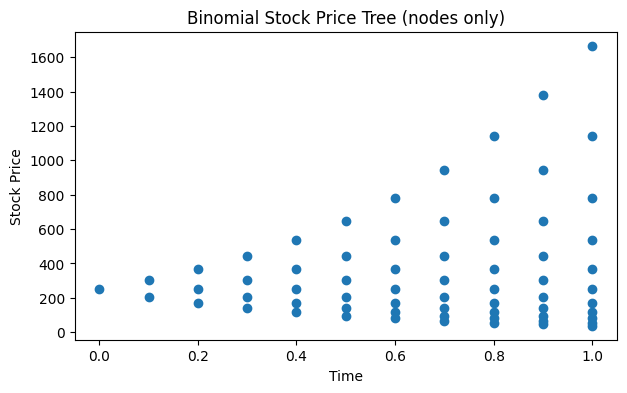

In [8]:
tree = build_stock_tree(S0=250, T=1.0, r=0.03, sigma=0.6, N=10)
plot_stock_tree(tree, T=1.0)


In [9]:
S0    = 440.0     
K     = 440.0     
T     = 0.25       
r     = 0.03      
q     = 0.0      
sigma = 0.49     
N     =  66     


In [10]:
call_price = binomial_european_crr(S0, K, T, r, sigma, N, option_type='call', q=0.0)
print(call_price)


44.24049631227122


In [14]:
def build_option_tree_crr(S0, K, T, r, sigma, N, option_type="call", american=False, q=0.0):
    S_tree, u, d, dt = build_stock_tree_crr(S0, T, r, sigma, N, q=q)
    disc = np.exp(-r * dt)
    p = (np.exp((r - q) * dt) - d) / (u - d)
    if not (0 <= p <= 1):
        raise ValueError(f"Risk-neutral p out of bounds: {p}")

   
    ST = S_tree[-1]
    if option_type == "call":
        V = np.maximum(ST - K, 0.0)
    else:
        V = np.maximum(K - ST, 0.0)

    V_tree = [None] * (N + 1)
    V_tree[N] = V.copy()

  
    for i in range(N - 1, -1, -1):
        V = disc * (p * V[1:i+2] + (1 - p) * V[0:i+1])
        if american:
            S_i = S_tree[i]
            if option_type == "call":
                exercise = np.maximum(S_i - K, 0.0)
            else:
                exercise = np.maximum(K - S_i, 0.0)
            V = np.maximum(V, exercise)

        V_tree[i] = V.copy()

    price = float(V_tree[0][0])
    return price, S_tree, V_tree, p, u, d, dt


In [15]:
Ns = [5, 10, 20, 50, 75, 100, 150, 200, 300, 400, 500, 750, 1000]

bin_prices = []
errors = []

for N in Ns:
    price_N, *_ = build_option_tree_crr(S0, K, T, r, sigma, N, option_type="call", american=False, q=q)
    bin_prices.append(price_N)
    errors.append(price_N - bs_call_price)

print("\n   N    Binomial Price    Error (Bin - BS)")
for N, pN, eN in zip(Ns, bin_prices, errors):
    print(f"{N:4d}   {pN:14.4f}   {eN: .6f}")


plt.figure(figsize=(7,4))
plt.plot(Ns, bin_prices, marker="o", label="Binomial (European Call)")
plt.axhline(bs_call_price, linestyle="--", label="Black–Scholes")
plt.xlabel("N (steps)")
plt.ylabel("Price")
plt.title("Convergence: Binomial → Black–Scholes (European Call)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(Ns, np.abs(errors), marker="o")
plt.yscale("log")
plt.xlabel("N (steps)")
plt.ylabel("|Binomial − BS| (log scale)")
plt.title("Convergence Error vs N")
plt.grid(True, which="both", ls="--")
plt.show()


NameError: name 'build_stock_tree_crr' is not defined